In [1]:
%load_ext autoreload
%autoreload 2

In [177]:
# from datetime import datetime
#
# pairs = [f"{coin}usdt" for coin in COINS]
# start = datetime(year=2023, month=7, day=23)
# end = datetime.now()
#
# limit = 900
# interval = '1m'
# from contextlib import contextmanager
#
# with RateWeight(total_weight=1000, update_period=62) as rate_weight:
#     res = await run_data_tasks(rate_weight, pairs, start, end, limit, interval)


In [178]:
%%time

bucket = "FUTURES"
measurement = "klines"

field_data, coin_data = get_data(
    measurement=measurement, bucket=bucket,
    aggregate_window='10m', aggregate_func='last'
)

CPU times: user 1min 16s, sys: 1.05 s, total: 1min 17s
Wall time: 1min 26s


In [6]:
# import numpy as np
# import pandas as pd
#
# def fisher_transform(r):
#     return 0.5 * np.log((1 + r) / (1 - r))
#
# def inverse_fisher_transform(z):
#     return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)
#
# WINDOW = 24 * 7
# df = np.log1p(field_data.close.pct_change()).rolling(WINDOW,  min_periods=WINDOW).corr()
# df_reset = df.reset_index()
# df_melt = df_reset.melt(id_vars=['_time', 'coin'], var_name='coin_pair', value_name='price')
# df_pivot = df_melt.pivot(index='_time', columns=['coin', 'coin_pair'], values='price')
#
#
#
# # columns = list(set(tuple(sorted(column)) for column in df_pivot.columns if (column[0] != column[1])))
# columns = list(column for column in df_pivot.columns if (column[0] != column[1]))
# df_pivot = df_pivot[columns]
# df_pivot = df_pivot.iloc[WINDOW:]
#
# df_save = df_melt[(df_melt['coin'] != df_melt['coin_pair']) & (~pd.isna(df_melt['price']))]
# # df_save = df_melt[(~pd.isna(df_melt['correlation']))]
# df_save = df_save.set_index('_time')
# # write_api = client.write_api()
# #
# # write_api.write(
# #     bucket=STATISTICS_BUCKET,
# #     record=df_save,
# #     data_frame_measurement_name=MEASUREMENT,
# #     data_frame_tag_columns=['coin', 'coin_pair']
# # )

In [180]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import statsmodels.tsa.stattools as ts
from itertools import combinations
import statsmodels.api as sm


df = field_data.close

def in_out_samples(data, frac=0.8) -> tuple[pd.DataFrame, pd.DataFrame]:
    frac_index = int(frac * len(data))
    in_sample = data.iloc[:frac_index]
    out_sample = data.iloc[:frac_index]
    return in_sample, out_sample


FROM_DATE = "2022-01-01"
TO_DATE = "2023-05-01"
FROM_DATE, TO_DATE = [pd.to_datetime(d).tz_localize('UTC') for d in (FROM_DATE, TO_DATE)]
df = df[(df.index > FROM_DATE)]


in_sample, out_sample = in_out_samples(df, frac=0.8)

in_sample = df[((df.index > FROM_DATE) & (df.index < TO_DATE))]
# in_sample = df[((df.index < TO_DATE))]

out_sample = df[df.index >=TO_DATE]

asset_pairs = list(combinations(COINS.keys(), 2))
#
# ols_data = []
# beta = {}
# ratio = {}
#
# results = {}
# for coin, coin_pair in tqdm(asset_pairs):
#     asset1 = in_sample[coin]
#     asset2 = in_sample[coin_pair]
#     rat = (asset1 / asset2).mean()
#
#
#     asset2 = sm.add_constant(asset2)
#
#     model = sm.OLS(asset1, asset2)
#     result = model.fit()
#
#     hedge_ratio = result.params[1]
#     intercept = result.params[0]
#     r_squared = result.rsquared
#     # Print out the statistics
#     ols_data.append([coin, coin_pair, rat, hedge_ratio, intercept, r_squared])
#     beta[(coin, coin_pair)] = hedge_ratio
#     results[(coin, coin_pair)] = result
#     ratio[(coin, coin_pair)] = rat
# ols_data = pd.DataFrame(ols_data, columns=['coin', 'coin_pair', 'ratio', 'hedge_ratio', 'intercept', 'r_squared'])
# ols_data

In [189]:
# in_sample_min = in_sample.rolling('180D', min_periods=10000).min()
# in_sample_max = in_sample.rolling('180D', min_periods=10000).max()

in_sample_min = in_sample.min()
in_sample_max = in_sample.max()


in_sample_normalized = ((in_sample - in_sample_min) / (in_sample_max - in_sample_min)).dropna()
# in_sample_normalized = (in_sample_normalized - 0.5) * 2
in_sample_normalized = in_sample_normalized + 1

# trend_window = '30D'
# in_sample_detrended = in_sample_normalized - in_sample_normalized.rolling(trend_window, min_periods=1500).mean()
# in_sample_detrended = in_sample_detrended.dropna()
# in_sample_detrended

In [190]:
import statsmodels.tsa.stattools as ts

def analyze_adfuller(series):
    result = ts.adfuller(series)
    return dict(zip(
        ['coin', 'coin_pair', 'adf', 'p_value', 'critical_1%', 'critical_5%', 'critical_10%'],
        [coin, coin_pair, result[0], result[1], *result[4].values()]
    ))

adf = []
current = in_sample_normalized

for coin, coin_pair in tqdm(asset_pairs):

    asset1 = current[coin]
    asset2 = current[coin_pair]
    spread = asset1 / asset2
    adf.append(analyze_adfuller(spread))

adf = pd.DataFrame(adf)


100%|██████████| 15/15 [02:06<00:00,  8.44s/it]


In [191]:
adf

,coin,coin_pair,adf,p_value,critical_1%,critical_5%,critical_10%
0,btc,eth,-1.581890,0.492684,-3.430444,-2.861581,-2.566792
1,btc,xrp,-2.190942,0.209550,-3.430444,-2.861581,-2.566792
2,btc,sol,-0.994356,0.755317,-3.430444,-2.861581,-2.566792
3,btc,ltc,-1.304488,0.627116,-3.430444,-2.861581,-2.566792
4,btc,ada,-0.923888,0.780004,-3.430444,-2.861581,-2.566792
5,eth,xrp,-2.411528,0.138509,-3.430444,-2.861581,-2.566792
6,eth,sol,-1.502295,0.532376,-3.430444,-2.861581,-2.566792
7,eth,ltc,-1.582058,0.492600,-3.430444,-2.861581,-2.566792
8,eth,ada,-1.495426,0.535773,-3.430444,-2.861581,-2.566792
9,xrp,sol,-2.285946,0.176541,-3.430444,-2.861581,-2.566792


In [ ]:
adf

In [109]:

df = field_data.close
df_normalized = ((df - in_sample.min()) / (in_sample.max() - in_sample.min())).dropna()

In [112]:
df_save = df_normalized.stack().reset_index()
df_save.columns = ['time', 'coin', 'price']
df_save = df_save.set_index("time")

from futures.db import get_client
client = get_client()

write_api = client.write_api()
bucket_api = client.buckets_api()

BUCKET = "COINTEGRATED"

bucket = bucket_api.find_bucket_by_name(BUCKET)

bucket_api.delete_bucket(bucket)

bucket_api.create_bucket(bucket_name=BUCKET)

write_api.write(
    bucket=BUCKET,
    record=df_save,
    data_frame_measurement_name='price',
    data_frame_tag_columns=['coin']
)

In [113]:

MIN_PERIOD = 6 * 24 * 10
trend_window = '10d'
df_sample_detrended = df_normalized - df_normalized.rolling(trend_window, min_periods=MIN_PERIOD).mean()
df_sample_detrended = df_sample_detrended.dropna()


current = df_sample_detrended

for coin, coin_pair in tqdm(asset_pairs):
    asset1 = current[coin]
    asset2 = current[coin_pair]
    stationary = asset1 - asset2
    stationary_mean = stationary.rolling(trend_window, min_periods=MIN_PERIOD).mean()
    stationary_std = stationary.rolling(trend_window, min_periods=MIN_PERIOD).std()
#
    stationary_normalized = (stationary - stationary_mean) / stationary_std
    stationary_normalized = stationary_normalized.dropna()

    st = pd.DataFrame(stationary_normalized, columns=['spread'])
    st['coin_pair'] = f"{coin}-{coin_pair}"

    write_api.write(
        bucket=BUCKET,
        record=st,
        data_frame_measurement_name='spread',
        data_frame_tag_columns=['coin_pair']
    )


100%|██████████| 15/15 [00:16<00:00,  1.08s/it]


<Axes: xlabel='_time'>

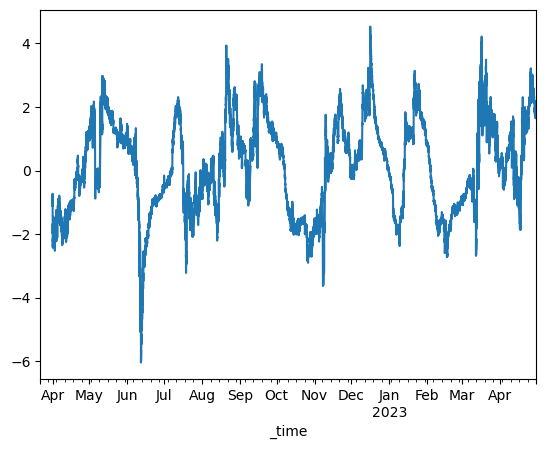

In [176]:
coin, coin_pair = "btc", "eth"
asset1 = current[coin]
asset2 = current[coin_pair]
stationary = asset1 - asset2
stationary_mean = stationary.rolling(trend_window, min_periods=MIN_PERIOD).mean()
stationary_std = stationary.rolling(trend_window, min_periods=MIN_PERIOD).std()
stationary_normalized = (stationary - stationary_mean) / stationary_std
stationary_normalized.plot()

In [142]:
len(stationary_normalized)

133201

In [140]:
stationary_normalized.mean()

-0.002489276509019197

In [120]:
np.log1p(df.pct_change())

coin,ada,btc,eth,ltc,sol,xrp
_time,,,,,,
2020-12-31 21:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-31 21:20:00+00:00,-0.000276,0.004861,-0.000377,0.002329,-0.001917,0.004450
2020-12-31 21:30:00+00:00,0.000111,-0.001752,-0.002967,-0.004342,-0.002517,-0.004450
2020-12-31 21:40:00+00:00,-0.000995,-0.001843,-0.001541,-0.000403,0.000597,-0.001339
2020-12-31 21:50:00+00:00,0.001161,-0.000794,-0.000149,0.001047,0.001060,0.001339
...,...,...,...,...,...,...
2023-07-24 20:20:00+00:00,-0.001318,0.000038,-0.000195,-0.000676,0.001027,-0.000142
2023-07-24 20:30:00+00:00,-0.000330,0.000367,-0.000108,-0.000451,-0.001584,-0.002697
2023-07-24 20:40:00+00:00,-0.002641,-0.001161,-0.000590,-0.002823,-0.002575,-0.004845


In [123]:
np.log1p(df.pct_change())

coin,ada,btc,eth,ltc,sol,xrp
_time,,,,,,
2020-12-31 21:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-31 21:20:00+00:00,-0.000276,0.004861,-0.000377,0.002329,-0.001917,0.004450
2020-12-31 21:30:00+00:00,0.000111,-0.001752,-0.002967,-0.004342,-0.002517,-0.004450
2020-12-31 21:40:00+00:00,-0.000995,-0.001843,-0.001541,-0.000403,0.000597,-0.001339
2020-12-31 21:50:00+00:00,0.001161,-0.000794,-0.000149,0.001047,0.001060,0.001339
...,...,...,...,...,...,...
2023-07-24 20:20:00+00:00,-0.001318,0.000038,-0.000195,-0.000676,0.001027,-0.000142
2023-07-24 20:30:00+00:00,-0.000330,0.000367,-0.000108,-0.000451,-0.001584,-0.002697
2023-07-24 20:40:00+00:00,-0.002641,-0.001161,-0.000590,-0.002823,-0.002575,-0.004845


In [57]:
# from statsmodels.tsa.vector_ar import vecm
#
# current = in_sample_normalized
# for coin, coin_pair in tqdm(asset_pairs):
#     ecm = vecm.VECM(in_sample_normalized[[coin,coin_pair]],deterministic='co')
#     est = ecm.fit()
#
#     est.plot_forecast(4,n_last_obs=100)
#     break

In [66]:
import statsmodels.tsa.stattools as ts

adf = []

current = in_sample

for coin in tqdm(COINS):

    asset = current[coin].pct_change().dropna()
    adf.append(analyze_adfuller(asset))

adf = pd.DataFrame(adf)
adf

100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


,coin,coin_pair,adf,p_value,critical_1%,critical_5%,critical_10%
0,btc,ada,-21.090838,0.0,-3.430632,-2.861664,-2.566836
1,eth,ada,-21.209153,0.0,-3.430632,-2.861664,-2.566836
2,xrp,ada,-22.917917,0.0,-3.430632,-2.861664,-2.566836
3,sol,ada,-21.753410,0.0,-3.430632,-2.861664,-2.566836
4,ltc,ada,-22.308619,0.0,-3.430632,-2.861664,-2.566836
5,ada,ada,-23.560308,0.0,-3.430632,-2.861664,-2.566836


In [53]:
# # Check, that cross-correlation is 0, means that returns are correlated without lag.
# current = in_sample.pct_change().dropna()
# for coin, coin_pair in tqdm(asset_pairs):
#     asset1 = current[coin]
#     asset2 = current[coin_pair]
#     print(ts.ccf(asset1, asset2)[:10])

In [36]:
# COINTEGRATED_PAIRS = [("btc", "eth"), ("eth", "xrp"), ("sol", "ada")]


In [129]:
import statsmodels.tsa.vector_ar.vecm as vecm
lag_order = 1

def analyze_adfuller(series):
    result = ts.adfuller(series)
    return dict(zip(
        ['coin', 'coin_pair', 'adf', 'p_value', 'critical_1%', 'critical_5%', 'critical_10%'],
        [coin, coin_pair, result[0], result[1], *result[4].values()]
    ))

# current = in_sample_detrended
current = in_sample
for coin, coin_pair in asset_pairs:

    pair_ = current[[coin, coin_pair]]

    # Calculate spread
    johansen_test = vecm.coint_johansen(pair_, det_order=0, k_ar_diff=lag_order)
    if johansen_test.lr1[0] > 0.9 * johansen_test.cvt[0][0]:
        print((coin, coin_pair), (johansen_test.lr1[0], johansen_test.cvt[0][0]), (johansen_test.lr2[0], johansen_test.cvm[0][0]))
        # print(f"PAIR ({coin}-{coin_pair})")
        # print(f'Trace statistics: {johansen_test.lr1}')
        # print(f'Critical values of trace statistics: {johansen_test.cvt}')
        # print(f'Max eigenvalue statistics: {johansen_test.lr2}')
        # print(f'Critical values of max eigenvalue statistics: {johansen_test.cvm}')
        # print('____________________')
    #
    # # print(result[4])
    # adf.append([coin, coin_pair, result[0], result[1], *result[4].values()])
    #


('btc', 'eth') (14.892104590454228, 13.4294) (12.193412685250218, 12.2971)
('btc', 'sol') (17.166828463180533, 13.4294) (15.450100324975969, 12.2971)
('btc', 'ltc') (13.375162743902056, 13.4294) (8.415952370911832, 12.2971)
('eth', 'xrp') (17.08177684428563, 13.4294) (12.25910157828965, 12.2971)
('eth', 'sol') (17.03808367235952, 13.4294) (13.133843682033092, 12.2971)
('eth', 'ltc') (13.547022989111618, 13.4294) (8.210496236240326, 12.2971)
('xrp', 'sol') (21.176272543241584, 13.4294) (16.7901678426067, 12.2971)
('xrp', 'ada') (12.156074207166446, 13.4294) (7.445650266737896, 12.2971)
('sol', 'ltc') (15.10566527285638, 13.4294) (12.285121906512021, 12.2971)
('sol', 'ada') (36.8885315810973, 13.4294) (27.830852136440864, 12.2971)


In [ ]:
"""
btc-eth ?
btc-sol

eth-xrp ?
"""

In [107]:
# d = in_sample[['sol', 'ada']]
ddd = in_sample[['btc', 'eth']]
d = ddd - ddd.rolling('30D').mean()
# d = in_sample[['eth', 'sol', 'ada']]

# Calculate spread
johansen_test = vecm.coint_johansen(d, det_order=0, k_ar_diff=lag_order)
print(f'Trace statistics: {johansen_test.lr1}')
print(f'Critical values of trace statistics: {johansen_test.cvt}')
print(f'Max eigenvalue statistics: {johansen_test.lr2}')
print(f'Critical values of max eigenvalue statistics: {johansen_test.cvm}')
print('____________________')

Trace statistics: [29.52684874 12.0836165 ]
Critical values of trace statistics: [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Max eigenvalue statistics: [17.44323224 12.0836165 ]
Critical values of max eigenvalue statistics: [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]
____________________


In [110]:
cointegrating_vector = johansen_test.evec[:, 0]
stat_portfolio = d.dot(cointegrating_vector)
analyze_adfuller(stat_portfolio)

{'coin': 'ltc',
 'coin_pair': 'ada',
 'adf': -4.159277564697932,
 'p_value': 0.0007716579914209437,
 'critical_1%': -3.430631254979239,
 'critical_5%': -2.8616643057737963,
 'critical_10%': -2.566836164400362}

<Axes: xlabel='_time'>

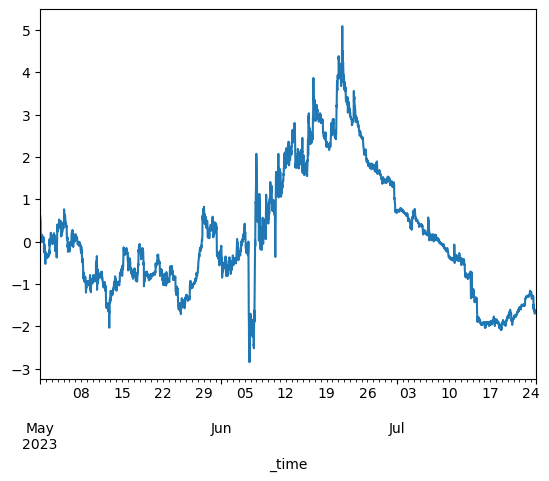

In [126]:
total = df[['btc', 'eth']]
total = total - total.rolling('30D').mean()
stationary = total.dot(cointegrating_vector)

stationary_mean = stationary.rolling('30d').mean()
stationary_std = stationary.rolling('30d').std()

stationary_normalized = (stationary - stationary_mean) / stationary_std
# stationary_normalized[stationary_normalized.index >= TO_DATE].plot()
stationary_normalized[stationary_normalized.index >= TO_DATE].plot()
# stationary_normalized.plot()

In [127]:
stationary_normalized.max()

5.380119272107866

<Axes: xlabel='_time'>

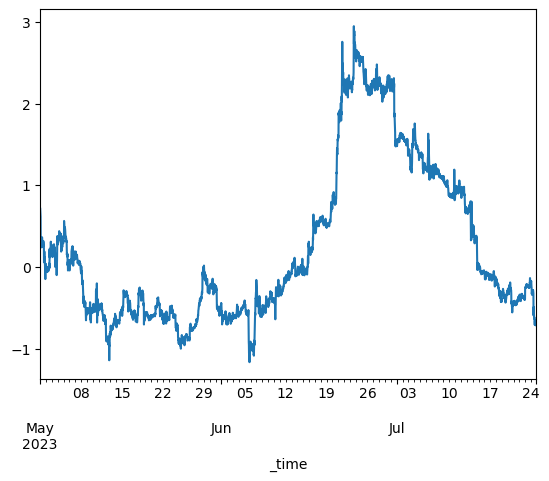

In [115]:
"""
SOL - ADA
BTC - ETH
ETH - XRP
"""



In [28]:
print("Eigenvalues (trace statistic):\n", johansen_test.lr1)
print("Trace statistics:\n", johansen_test.cvt[:, 1])  # 5% critical value
print("Critical values (90%, 95%, 99%):\n", johansen_test.cvt)

Eigenvalues (trace statistic):
 [84.26729759 49.06834435 27.09366644 16.98423205  9.03836655  2.97939849]
Trace statistics:
 [95.7542 69.8189 47.8545 29.7961 15.4943  3.8415]
Critical values (90%, 95%, 99%):
 [[ 91.109   95.7542 104.9637]
 [ 65.8202  69.8189  77.8202]
 [ 44.4929  47.8545  54.6815]
 [ 27.0669  29.7961  35.4628]
 [ 13.4294  15.4943  19.9349]
 [  2.7055   3.8415   6.6349]]


In [54]:
adf

,coin,coin_pair,adf,p_value,critical_1%,critical_5%,critical_10%
0,btc,ada,-21.090838,0.0,-3.430632,-2.861664,-2.566836
1,eth,ada,-21.209153,0.0,-3.430632,-2.861664,-2.566836
2,xrp,ada,-22.917917,0.0,-3.430632,-2.861664,-2.566836
3,sol,ada,-21.753410,0.0,-3.430632,-2.861664,-2.566836
4,ltc,ada,-22.308619,0.0,-3.430632,-2.861664,-2.566836
5,ada,ada,-23.560308,0.0,-3.430632,-2.861664,-2.566836


In [71]:
# """

# """
# from statsmodels.stats.stattools import durbin_watson
# from scipy import stats
# from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
# from statsmodels.compat import lzip
#
# correctness = []
# # Perform the Rainbow test for linearity
# for coin, coin_pair in tqdm(asset_pairs):
#     result = results[coin, coin_pair]
#     rainbow_stat, rainbow_p_value = linear_rainbow(result)
#     dw = durbin_watson(result.resid)
#
#     labels = []
#     l_mul = het_breuschpagan(result.resid, result.model.exog)
#     jb = stats.jarque_bera(result.resid)
#
#     correctness.append((coin, coin_pair, rainbow_stat, rainbow_p_value, dw, *l_mul, jb[0], jb[1]))
#
# correctness = pd.DataFrame(
#     correctness,
#     columns=['coin', 'coin_pair', 'rainbow_stat', 'rainbow_p_value', 'durbin_watson', 'l_mul_statistic', 'l_mul_value', 'l_mul_f_value', 'l_mul_p_value', 'jarque_bera_stat', 'jarque_bera_p_value']
# )
#
# # correctness

100%|██████████| 15/15 [00:00<00:00, 222.26it/s]


In [90]:
(in_sample['btc'] / in_sample['eth']).resample('M').mean()

_time
2022-01-31 00:00:00+00:00    13.570325
2022-02-28 00:00:00+00:00    14.198567
2022-03-31 00:00:00+00:00    14.630218
2022-04-30 00:00:00+00:00    13.394777
2022-05-31 00:00:00+00:00    14.585113
2022-06-30 00:00:00+00:00    17.801642
2022-07-31 00:00:00+00:00    16.245578
2022-08-31 00:00:00+00:00    13.202167
2022-09-30 00:00:00+00:00    13.413860
2022-10-31 00:00:00+00:00    14.433662
2022-11-30 00:00:00+00:00    13.575916
2022-12-31 00:00:00+00:00    13.702315
2023-01-31 00:00:00+00:00    13.753105
2023-02-28 00:00:00+00:00    14.336698
2023-03-31 00:00:00+00:00    14.929548
2023-04-30 00:00:00+00:00    15.053599
Freq: M, dtype: float64

In [97]:
in_sample_detrended = in_sample - in_sample.rolling(window='30d', min_periods=200).mean()
in_sample_detrended = in_sample_detrended.dropna()
in_sample_detrended

coin,ada,btc,eth,ltc,sol,xrp
_time,,,,,,
2022-01-09 08:00:00+00:00,-0.110373,-3070.039526,-433.861097,-12.006469,-19.628404,-0.055158
2022-01-09 09:00:00+00:00,-0.117329,-3144.201518,-443.737410,-12.367963,-20.534896,-0.057610
2022-01-09 10:00:00+00:00,-0.123996,-3255.102644,-454.315301,-12.706745,-21.194285,-0.059990
2022-01-09 11:00:00+00:00,-0.127367,-3295.041889,-460.096927,-12.764720,-21.329195,-0.060613
2022-01-09 12:00:00+00:00,-0.120550,-3023.699484,-434.118247,-11.833261,-19.834323,-0.055069
...,...,...,...,...,...,...
2023-04-30 19:00:00+00:00,0.003391,787.229884,3.812206,-2.013279,1.254731,-0.017273
2023-04-30 20:00:00+00:00,-0.001733,551.227139,-11.358747,-2.931231,0.984518,-0.020315
2023-04-30 21:00:00+00:00,-0.007386,451.202669,-27.562331,-3.817438,0.836078,-0.024386
